# 텐서플로 허브의 사전 훈련 모델로 SSD 객체 탐지 추론

## 텐서플로 허브의 사전 훈련 SSD 모델 사용법

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

print(tf.__version__)

2.8.2


In [2]:
!nvidia-smi

Thu Jun  2 15:31:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!mkdir /content/data
!wget -O ./data/beatles01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg

--2022-06-02 15:31:30--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383118 (374K) [image/jpeg]
Saving to: ‘./data/beatles01.jpg’

./data/beatles01.jp 100%[===================>] 374.14K  --.-KB/s    in 0.005s  

2022-06-02 15:31:30 (73.0 MB/s) - ‘./data/beatles01.jpg’ saved [383118/383118]



#### 텐서플로 허브의 사전 훈련 SSD 모델 다운로드 후 Inference 수행
* 원하는 모델명은 텐서플로 허브에서 검색해 hub.lod()로 불러올 수 있음
* 불러운 모델은 바로 원본 이미지를 사용해 객체 탐지를 수행할 수 있음(입력 이미지 값으로 넘파이 배열과 텐서 모두 가능하며 uint8로 설정 필요)
* 객체 탐지 inference 결과는 딕셔너리 형태로 반환되며, 개별 key값은 모델에 따라 다름(개별 value는 텐서 타입임)
* 예측한 경계 박스 좌표는 이미지 크기 대비 정규화된 0~1 사이 값이며 **y_min, x_min, y_max, x_max 형태로 반환됨에 유의**

In [4]:
# https://tfhub.dev/에서 SSD MobileNet v2 사전 훈련 모델 불러오기
detector_model = hub.load("https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2")

In [5]:
import cv2
import numpy as np

img_array = cv2.imread('/content/data/beatles01.jpg')

# 차원 추가(3차원 넘파이 배열을 4차원으로 변경) ---①
img_array_newaxis = img_array[np.newaxis, ...]

print(img_array.shape, img_array_newaxis.shape)

(633, 806, 3) (1, 633, 806, 3)


In [6]:
import time

start_time = time.time()
# 4차원 이미지 배열을 전달해 inference 수행
result = detector_model(img_array_newaxis)
end_time = time.time()

print('infernece 수행 시간:', end_time - start_time)

infernece 수행 시간: 13.628958702087402


In [7]:
# 이미지 넘파이 배열을 4차원 텐서로 변환(dtype=tf.uint8로 해야 함에 유의!)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]

start_time = time.time()
result = detector_model(img_tensor)
end_time = time.time()

print('infernece 수행 시간:', end_time - start_time)

infernece 수행 시간: 0.07636070251464844


In [8]:
result

{'detection_anchor_indices': <tf.Tensor: shape=(1, 100), dtype=float32, numpy=
 array([[1475.,  435., 1453.,  432.,  369., 1465.,  372.,  420.,  366.,
          470.,  429.,  441.,  477., 1487.,  447.,  444.,  438.,  375.,
          477.,  501.,  450.,  435.,  617.,  477.,  593.,  423.,  363.,
          378.,  605.,  578.,  441.,  366.,  453.,  489.,  438.,  462.,
         1457.,  477.,  363.,  420., 1015., 1575.,  420., 1569.,  465.,
          489.,  495., 1555., 1472., 1569.,  495., 1543.,  474.,  477.,
          417.,  593.,  717.,  432.,  423.,  465.,  492.,  309.,  433.,
          420.,  378.,  447.,  498.,  369.,  372.,  759., 1580.,  417.,
          444.,  534.,  375.,  474.,  408.,  501.,  453.,  717., 1611.,
          450.,  651.,  462.,  495.,  498.,  426.,  821., 1520.,  720.,
          489.,  312.,  591.,  761.,  357.,  390.,  546.,  438., 1796.,
          717.]], dtype=float32)>,
 'detection_boxes': <tf.Tensor: shape=(1, 100, 4), dtype=float32, numpy=
 array([[[0.41495627,

In [9]:
result.keys()

dict_keys(['num_detections', 'detection_scores', 'raw_detection_scores', 'detection_boxes', 'detection_anchor_indices', 'raw_detection_boxes', 'detection_multiclass_scores', 'detection_classes'])

In [10]:
# 100개를 기본으로 탐지함(즉 탐지한 객체는 무조건 100개. 그래서 tensor(array)는 100개 단위)
print(result['detection_boxes'].shape, result['detection_classes'].shape)

(1, 100, 4) (1, 100)


In [11]:
# 탐지한 객체는 신뢰도가 높은 순으로 출력
print('######## detection_classes #########')
print(result['detection_classes'])
print('######## detection_scores #########')
print(result['detection_scores'])

######## detection_classes #########
tf.Tensor(
[[ 1.  3.  1.  3.  3.  1.  3.  3.  3.  3.  3.  3.  1.  1.  3.  3.  3.  3.
   3.  1.  3.  8.  1.  4.  1.  3.  3.  3.  1.  1.  1.  1.  3.  1.  1.  1.
   1.  2.  1.  1. 41. 15. 15.  9.  1.  3.  3.  1.  1. 15.  4.  1.  1. 15.
   1. 28. 37.  8.  1.  3.  4. 10.  3.  8.  1.  1.  3.  1.  1. 31.  9.  3.
   1.  1.  8.  3.  1.  3.  1. 31. 15.  1. 31.  3.  1.  1.  3.  1.  1. 37.
   4. 10. 31. 31.  3.  1.  1.  8.  1. 34.]], shape=(1, 100), dtype=float32)
######## detection_scores #########
tf.Tensor(
[[0.80172944 0.7356188  0.7120171  0.69413865 0.6636528  0.65565026
  0.6452407  0.603727   0.6026705  0.5842154  0.56527376 0.5350405
  0.5342654  0.5268757  0.52053607 0.5095628  0.4978297  0.4945502
  0.4944435  0.4815372  0.4632207  0.44348982 0.43932405 0.43850383
  0.4356333  0.4294043  0.4046916  0.40248072 0.4004219  0.38804975
  0.379697   0.37923127 0.3572933  0.35150284 0.3513087  0.34515974
  0.34445184 0.3431205  0.3409394  0.3407754  0.33898

In [12]:
# 경계 박스 좌표는 y_min, x_min, y_max, x_max 순서로 반환
# 좌표 값은 원본 이미지의 너비와 높이 기준으로 0~1 사이값으로 정규화됨. 
result['detection_boxes']

<tf.Tensor: shape=(1, 100, 4), dtype=float32, numpy=
array([[[0.41495627, 0.4789078 , 0.8861094 , 0.6805986 ],
        [0.35446185, 0.6193308 , 0.45601124, 0.7103389 ],
        [0.42462415, 0.07202519, 0.8726056 , 0.24962677],
        [0.34840307, 0.57042307, 0.4265056 , 0.6450172 ],
        [0.351907  , 0.49550375, 0.37206447, 0.51862085],
        [0.43273562, 0.2820462 , 0.8654354 , 0.45395404],
        [0.3487833 , 0.5463882 , 0.37784773, 0.5763231 ],
        [0.3735987 , 0.38559082, 0.41415024, 0.42749032],
        [0.3549313 , 0.45743853, 0.3715493 , 0.4719668 ],
        [0.3873283 , 0.16212597, 0.54663444, 0.31490028],
        [0.35574898, 0.53846586, 0.41043958, 0.595577  ],
        [0.35995895, 0.74961007, 0.4518572 , 0.80073214],
        [0.41962263, 0.37767807, 0.49098232, 0.41628668],
        [0.40850347, 0.6971656 , 0.8881627 , 0.8754239 ],
        [0.37630147, 0.8410377 , 0.4158867 , 0.88230294],
        [0.3869046 , 0.8088866 , 0.42234337, 0.8531973 ],
        [0.35546145

## inference 결과 시각화

### 이미지 활용 inference 결과 시각화

In [13]:
# 1부터 91까지 COCO 클래스 ID 매핑
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}

In [14]:
import matplotlib.pyplot as plt

def get_detected_img(model, img_array, score_threshold, object_show_count=100, score_print=True, time_print=True):   

    # 원본 이미지의 형상 정보 ---①
    rows = img_array.shape[0]
    cols = img_array.shape[1]

    img_copy = img_array.copy() # 원본 이미지 복사본

    green_color = (0, 255, 0) # 경계 박스 테두리 색상
    red_color = (255, 0, 0)   # 텍스트 색상

    # 입력값 변환(1. 넘파이→텐서, 2. 타입 unit8, 3. 3차원→4차원) ---②
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]

    start_time = time.time()

    result = model(img_tensor) # 객체 탐지 inference 수행

    end_time = time.time()

    # result의 값을 모두 넘파이로 변환 ---③
    result = {key:value.numpy() for key,value in result.items()}

    # 탐지된 객체들을 순회하면서 정보 추출(탐지하는 기본 객체 개수는 100개) ---④
    for i in range(min(len(result['detection_scores'][0]), object_show_count)):
        # 크기가 큰 순서로 신뢰도를 추출하되, 신뢰도 임계값보다 낮으면 제외 ---⑤
        confidence_score = result['detection_scores'][0, i]
        if confidence_score < score_threshold:
            break

        box = result['detection_boxes'][0, i] # 경계 박스 좌표
        # 탐지한 경계 박스 좌표는 정규화되었으므로 다시 원본 이미지 비율로 복원 ---⑥
        # 예측한 경계 박스 좌표는 y_min, x_min, y_max, x_max 순서임에 유의
        x_min  = box[1] * cols
        y_min = box[0] * rows
        x_max  = box[3] * cols
        y_max  = box[2] * rows

        # 클래스 ID를 구해 클래스명 매핑
        class_id = result['detection_classes'][0, i]
        class_name = labels_to_names[class_id] # 클래스명

        caption = f'{class_name}: {confidence_score:.4f}'
        if score_print:
            print(caption)

        # 경계 박스와 캡션(클래스명, 신뢰도 점수) 표시(위치 인자는 반드시 정수형)
        cv2.rectangle(img_copy, (int(x_min), int(y_min)), (int(x_max), int(y_max)), 
                        color=green_color, thickness=2)
        cv2.putText(img_copy, caption, (int(x_min), int(y_min - 5)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, red_color, 2)

    if time_print:
        print('** 객체 탐지 inference 수행시간:', round(end_time - start_time, 2), '초')

    return img_copy

person: 0.7767
person: 0.7362
car: 0.7209
person: 0.7084
car: 0.6868
person: 0.6846
car: 0.6652
car: 0.6145
car: 0.5854
car: 0.5724
car: 0.5606
car: 0.5341
person: 0.5228
** 객체 탐지 inference 수행시간: 0.05 초


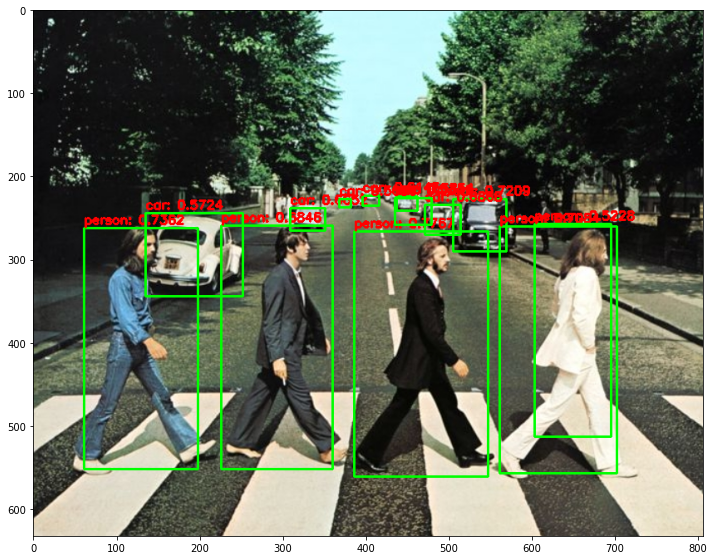

In [15]:
img_array = cv2.cvtColor(cv2.imread('/content/data/beatles01.jpg'), cv2.COLOR_BGR2RGB)

detected_img = get_detected_img(detector_model, img_array, 0.5)   
plt.figure(figsize=(12, 12))
plt.imshow(detected_img);

--2022-06-02 15:32:06--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/baseball01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76279 (74K) [image/jpeg]
Saving to: ‘./data/baseball01.jpg’

./data/baseball01.j 100%[===================>]  74.49K  --.-KB/s    in 0.002s  

2022-06-02 15:32:06 (46.7 MB/s) - ‘./data/baseball01.jpg’ saved [76279/76279]

person: 0.8886
person: 0.8754
person: 0.8638
baseball bat: 0.5842
baseball glove: 0.5645
baseball glove: 0.5182
baseball bat: 0.5007
** 객체 탐지 inference 수행시간: 0.07 초


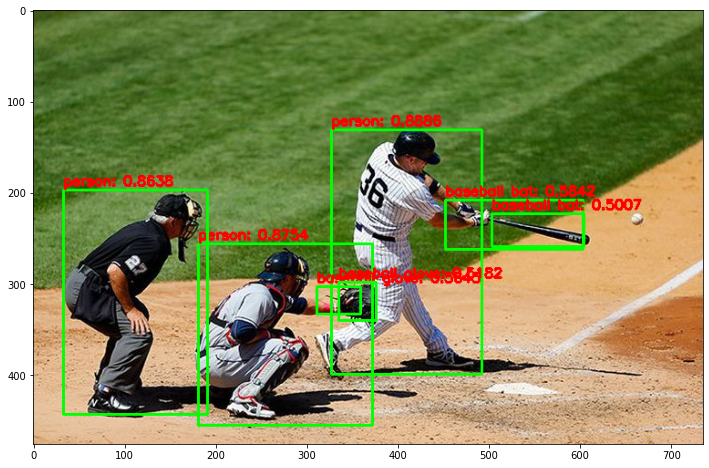

In [16]:
!wget -O ./data/baseball01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/baseball01.jpg

img_array = cv2.cvtColor(cv2.imread('/content/data/baseball01.jpg'), cv2.COLOR_BGR2RGB)

detected_img = get_detected_img(detector_model, img_array, 0.5)   
plt.figure(figsize=(12, 12))
plt.imshow(detected_img);

### 영상 활용 inference 결과 시각화

In [17]:
def write_detected_video(model, input_path, output_path, score_threshold, score_print=False, time_print=False):
    cap = cv2.VideoCapture(input_path) # 비디오 캡쳐 객체 생성

    codec = cv2.VideoWriter_fourcc(*'XVID') # Codec은 *'XVID'로 설정

    video_fps = cap.get(cv2.CAP_PROP_FPS)                  # FPS(Frames Per Second)
    video_width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)        # 비디오 캡쳐 객체 프레임의 너비
    video_height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)      # 비디오 캡쳐 객체 프레임의 높이
    video_size = (round(video_width), round(video_height)) # 비디오 크기 
    # VideoWriter 객체 생성
    video_writer = cv2.VideoWriter(output_path, codec, video_fps, video_size) 

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) # Frame 개수

    while True:
        hasFrame, img_frame = cap.read() # 비디오 캡쳐 객체에서 Frame 하나 읽기 
        if not hasFrame: # 처리할 Frame이 없으면 중단
            break
        # 해당 프레임 이미지를 활용해 객체 탐지 inference 수행
        img_frame = get_detected_img(model, img_frame, score_threshold=score_threshold, object_show_count=100, score_print=score_print, time_print=time_print)
        video_writer.write(img_frame)

    video_writer.release() # video_writer 닫기
    cap.release() # cap 닫기

In [18]:
!wget -O ./data/Jonh_Wick_small.mp4 https://github.com/chulminkw/DLCV/blob/master/data/video/John_Wick_small.mp4?raw=true

write_detected_video(detector_model, '/content/data/Jonh_Wick_small.mp4', './data/John_Wick_small_02.mp4', 0.5)

--2022-06-02 15:32:07--  https://github.com/chulminkw/DLCV/blob/master/data/video/John_Wick_small.mp4?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/chulminkw/DLCV/raw/master/data/video/John_Wick_small.mp4 [following]
--2022-06-02 15:32:07--  https://github.com/chulminkw/DLCV/raw/master/data/video/John_Wick_small.mp4
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/John_Wick_small.mp4 [following]
--2022-06-02 15:32:08--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/John_Wick_small.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.